<a href="https://colab.research.google.com/github/MichelleAppel/distribution-aware-image-to-image-translation/blob/master/toy_examples/Fly_VAE_weighted.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### imports



In [1]:
import os.path
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
import torchvision.transforms as transforms

from itertools import chain

import numpy as np
import math
import itertools
import random

from scipy import signal

import matplotlib.pyplot as plt

import zipfile

from sklearn.manifold import TSNE

# Fly data experiment

Todo:
*   Use annotations somehow for evaluation of distribution net

## The Fly dataset

In [2]:
zipdataroot_A = '/content/drive/MyDrive/fly_data_ubc_2021/generated_fly_with_annotation.zip'
zipdataroot_B = '/content/drive/MyDrive/fly_data_ubc_2021/real_fly.zip'

dataroot_A = '/content/flydata/data_A'
dataroot_B = '/content/flydata/data_B'

if not os.path.exists(dataroot_A):
  with zipfile.ZipFile(zipdataroot_A, 'r') as zip_ref:
      zip_ref.extractall(dataroot_A)

if not os.path.exists(dataroot_B):
  with zipfile.ZipFile(zipdataroot_B, 'r') as zip_ref:
      zip_ref.extractall(dataroot_B)

In [3]:
IMG_EXTENSIONS = [
    '.jpg', '.JPG', '.jpeg', '.JPEG',
    '.png', '.PNG', '.ppm', '.PPM', '.bmp', '.BMP',
]

def is_image_file(filename):
    return any(filename.endswith(extension) for extension in IMG_EXTENSIONS)

def make_dataset(dir):
    images = []
    assert os.path.isdir(dir), '%s is not a valid directory' % dir

    for root, _, fnames in sorted(os.walk(dir)):
        for fname in fnames:
            if is_image_file(fname) and not fname.endswith('real_A.png') and not fname.endswith('render_pose.png'):
                path = os.path.join(root, fname)
                images.append(path)

    return images

In [4]:
def __adjust(img):
    ow, oh = img.size

    # the size needs to be a multiple of this number,
    # because going through generator network may change img size
    # and eventually cause size mismatch error
    mult = 4
    if ow % mult == 0 and oh % mult == 0:
        return img
    w = (ow - 1) // mult
    w = (w + 1) * mult
    h = (oh - 1) // mult
    h = (h + 1) * mult

    return img.resize((w, h), Image.BICUBIC)

def normalize(img):
  return img * 2 - 1


def get_transform():
    loadSize = 128
    osize = [loadSize, loadSize]

    transform_list = []
    transform_list.append(transforms.Lambda(
            lambda img: __adjust(img)))
    
    transform_list.append(transforms.Resize(osize, Image.BICUBIC))  
    transform_list += [transforms.ToTensor()]
                      #  transforms.Normalize((0.5, 0.5, 0.5),
                      #                       (0.5, 0.5, 0.5))]
    transform_list.append(transforms.Lambda(
            lambda img: normalize(img)))
    
    return transforms.Compose(transform_list)

In [5]:
class FlyDataset(Dataset):
  def __init__(self):
    self.dataroot_A = dataroot_A
    self.dataroot_B = dataroot_B

    self.A_paths = make_dataset(self.dataroot_A)
    self.B_paths = make_dataset(self.dataroot_B)

    self.A_size = len(self.A_paths)
    self.B_size = len(self.B_paths)

    self.dir_len = len(self.dataroot_A) + 1

    self.transform = get_transform()

  def __getitem__(self, index):
      A_path = self.A_paths[index % self.A_size]
      A_name = A_path[self.dir_len:]
      
      index_B = random.randint(0, self.B_size - 1)
          
      B_path = self.B_paths[index_B]

      A_img = Image.open(A_path).convert('RGB')
      B_img = Image.open(B_path).convert('RGB')

      A = self.transform(A_img)
      B = self.transform(B_img)

      return {'A': A, 'B': B}

  def __len__(self):
    return max(self.A_size, self.B_size)

In [6]:
dataset = FlyDataset()

batch_size = 32
dataloader = DataLoader(dataset, batch_size, shuffle=True)

In [7]:
def visualize(img):
  plt.imshow((img.permute(1,2,0) + 1) / 2)
  plt.show()

## The VAE network

We use a VAE to encode the latent space of the fly images. The latent space of a VAE is structued as a distribution with mean $\mu$ and variance $\sigma$. This distribution is later used to determine the frequency of the samples with our distribution net.

In [69]:
# VAE code from https://github.com/podgorskiy/VAE

class VAE(nn.Module):
    def __init__(self, zsize, layer_count=5, channels=3):
        super(VAE, self).__init__()

        d = 128
        self.d = d
        self.zsize = zsize

        self.layer_count = layer_count

        mul = 1
        inputs = channels
        for i in range(self.layer_count):
            setattr(self, "conv%d" % (i + 1), nn.Conv2d(inputs, d * mul, 4, 2, 1))
            setattr(self, "conv%d_bn" % (i + 1), nn.BatchNorm2d(d * mul))
            inputs = d * mul
            mul *= 2

        self.d_max = inputs

        self.fc1 = nn.Linear(inputs * 4 * 4, zsize)
        self.fc2 = nn.Linear(inputs * 4 * 4, zsize)

        self.d1 = nn.Linear(zsize, inputs * 4 * 4)

        mul = inputs // d // 2

        for i in range(1, self.layer_count):
            setattr(self, "deconv%d" % (i + 1), nn.ConvTranspose2d(inputs, d * mul, 4, 2, 1))
            setattr(self, "deconv%d_bn" % (i + 1), nn.BatchNorm2d(d * mul))
            inputs = d * mul
            mul //= 2

        setattr(self, "deconv%d" % (self.layer_count + 1), nn.ConvTranspose2d(inputs, channels, 4, 2, 1))

    def encode(self, x):
        for i in range(self.layer_count):
            x = F.relu(getattr(self, "conv%d_bn" % (i + 1))(getattr(self, "conv%d" % (i + 1))(x)))

        x = x.view(x.shape[0], self.d_max * 4 * 4)
        h1 = self.fc1(x)
        h2 = self.fc2(x)
        return h1, h2

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, x):
        x = x.view(x.shape[0], self.zsize)
        x = self.d1(x)
        x = x.view(x.shape[0], self.d_max, 4, 4)
        #x = self.deconv1_bn(x)
        x = F.leaky_relu(x, 0.2)

        for i in range(1, self.layer_count):
            x = F.leaky_relu(getattr(self, "deconv%d_bn" % (i + 1))(getattr(self, "deconv%d" % (i + 1))(x)), 0.2)

        x = F.tanh(getattr(self, "deconv%d" % (self.layer_count + 1))(x))
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        mu = mu.squeeze()
        logvar = logvar.squeeze()
        z = self.reparameterize(mu, logvar)
        return self.decode(z.view(-1, self.zsize, 1, 1)), mu, logvar

    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)


def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

## Training the VAE

In [11]:
def loss_function(recon_x, x, mu, logvar):
    BCE = torch.mean((recon_x - x)**2)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(torch.mean(1 + logvar - mu.pow(2) - logvar.exp(), 1))
    return BCE, KLD * 0.1

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


epoch 0 step 0 loss_re_AB 0.909747838973999 loss_kl_AB 0.011996415443718433


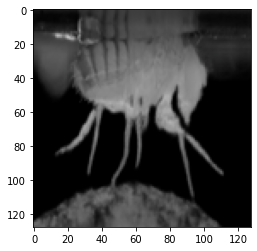

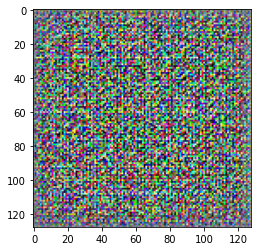

epoch 0 step 10 loss_re_AB 0.36087363958358765 loss_kl_AB 0.1522609442472458
epoch 0 step 20 loss_re_AB 0.22484686970710754 loss_kl_AB 0.03462513908743858
epoch 0 step 30 loss_re_AB 0.1564326286315918 loss_kl_AB 0.9305843710899353
epoch 0 step 40 loss_re_AB 0.15825381875038147 loss_kl_AB 0.044011130928993225
epoch 1 step 0 loss_re_AB 0.19951367378234863 loss_kl_AB 0.055234212428331375


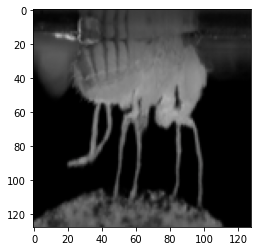

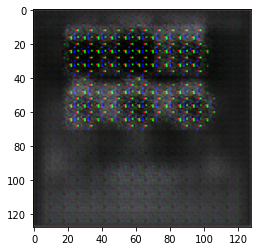

epoch 1 step 10 loss_re_AB 0.1212243065237999 loss_kl_AB 0.6997632384300232
epoch 1 step 20 loss_re_AB 0.12957820296287537 loss_kl_AB 0.40324124693870544
epoch 1 step 30 loss_re_AB 0.1720520704984665 loss_kl_AB 0.2116333544254303
epoch 1 step 40 loss_re_AB 0.07185950875282288 loss_kl_AB 0.115831159055233
epoch 2 step 0 loss_re_AB 0.15632149577140808 loss_kl_AB 0.07940969616174698


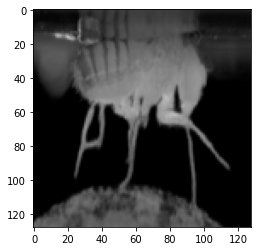

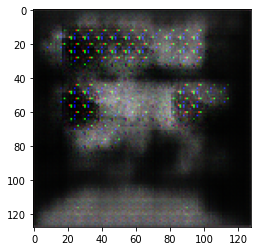

epoch 2 step 10 loss_re_AB 0.051025621592998505 loss_kl_AB 0.222234845161438
epoch 2 step 20 loss_re_AB 0.04781679809093475 loss_kl_AB 0.5423052906990051
epoch 2 step 30 loss_re_AB 0.05493687838315964 loss_kl_AB 0.8994617462158203
epoch 2 step 40 loss_re_AB 0.054642170667648315 loss_kl_AB 0.1232382282614708
epoch 3 step 0 loss_re_AB 0.041294097900390625 loss_kl_AB 0.1703198254108429


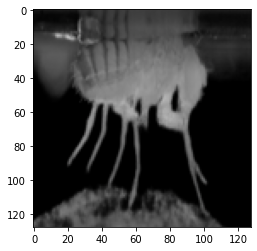

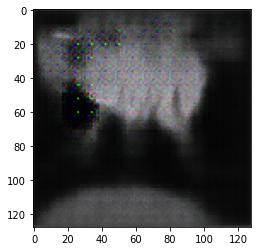

epoch 3 step 10 loss_re_AB 0.03898453712463379 loss_kl_AB 0.3655011057853699
epoch 3 step 20 loss_re_AB 0.0331566259264946 loss_kl_AB 0.09587866067886353
epoch 3 step 30 loss_re_AB 0.038049474358558655 loss_kl_AB 0.07470593601465225
epoch 3 step 40 loss_re_AB 0.031883060932159424 loss_kl_AB 0.06332731246948242
epoch 4 step 0 loss_re_AB 0.03078882023692131 loss_kl_AB 0.06774580478668213


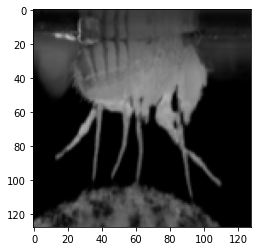

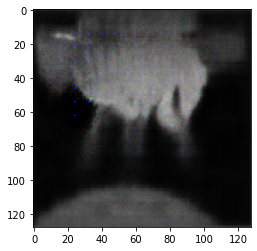

epoch 4 step 10 loss_re_AB 0.029174137860536575 loss_kl_AB 0.10539921373128891
epoch 4 step 20 loss_re_AB 0.028166264295578003 loss_kl_AB 0.059214022010564804
epoch 4 step 30 loss_re_AB 0.029954012483358383 loss_kl_AB 0.11636661738157272
epoch 4 step 40 loss_re_AB 0.02892003208398819 loss_kl_AB 0.07695916295051575
epoch 5 step 0 loss_re_AB 0.029070306569337845 loss_kl_AB 0.12018876522779465


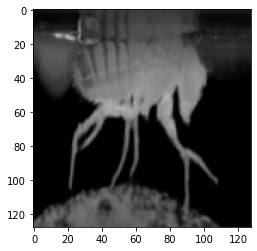

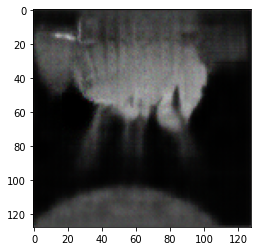

epoch 5 step 10 loss_re_AB 0.02921641618013382 loss_kl_AB 0.35206928849220276
epoch 5 step 20 loss_re_AB 0.03273497149348259 loss_kl_AB 0.29831621050834656
epoch 5 step 30 loss_re_AB 0.028197264298796654 loss_kl_AB 0.2862456738948822
epoch 5 step 40 loss_re_AB 0.06611309200525284 loss_kl_AB 0.13315419852733612
epoch 6 step 0 loss_re_AB 0.031692199409008026 loss_kl_AB 0.2329147905111313


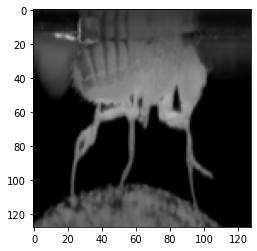

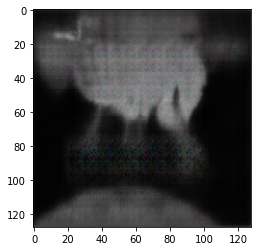

epoch 6 step 10 loss_re_AB 0.05675525590777397 loss_kl_AB 0.14820851385593414
epoch 6 step 20 loss_re_AB 0.0282144658267498 loss_kl_AB 0.19795635342597961
epoch 6 step 30 loss_re_AB 0.027977224439382553 loss_kl_AB 0.5486627817153931
epoch 6 step 40 loss_re_AB 0.02926710806787014 loss_kl_AB 0.12153322994709015
learning rate change!
epoch 7 step 0 loss_re_AB 0.027207180857658386 loss_kl_AB 0.17382672429084778


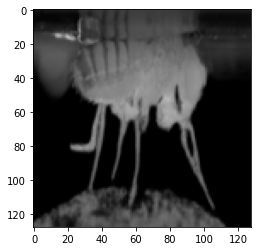

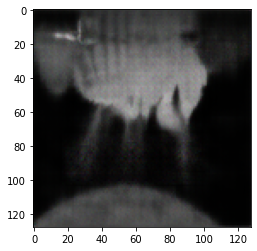

epoch 7 step 10 loss_re_AB 0.027374213561415672 loss_kl_AB 0.13011233508586884
epoch 7 step 20 loss_re_AB 0.026283148676156998 loss_kl_AB 0.11684014648199081
epoch 7 step 30 loss_re_AB 0.027638180181384087 loss_kl_AB 0.1084761843085289
epoch 7 step 40 loss_re_AB 0.027258258312940598 loss_kl_AB 0.102982297539711
epoch 8 step 0 loss_re_AB 0.026681995019316673 loss_kl_AB 0.09950076788663864


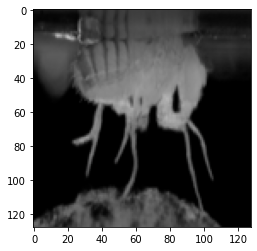

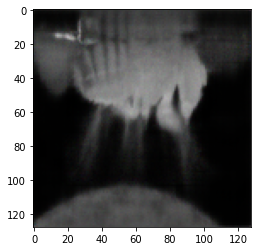

epoch 8 step 10 loss_re_AB 0.026871448382735252 loss_kl_AB 0.09496278315782547
epoch 8 step 20 loss_re_AB 0.02627374790608883 loss_kl_AB 0.09082497656345367
epoch 8 step 30 loss_re_AB 0.026625048369169235 loss_kl_AB 0.08680759370326996
epoch 8 step 40 loss_re_AB 0.026978429406881332 loss_kl_AB 0.08292590081691742
epoch 9 step 0 loss_re_AB 0.026808466762304306 loss_kl_AB 0.0804213285446167


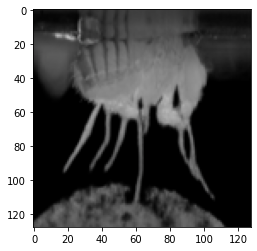

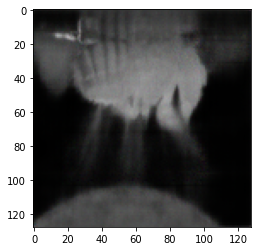

epoch 9 step 10 loss_re_AB 0.027618711814284325 loss_kl_AB 0.07682245969772339
epoch 9 step 20 loss_re_AB 0.02656596526503563 loss_kl_AB 0.07319601625204086
epoch 9 step 30 loss_re_AB 0.026312557980418205 loss_kl_AB 0.06987464427947998
epoch 9 step 40 loss_re_AB 0.025957947596907616 loss_kl_AB 0.06509269773960114
epoch 10 step 0 loss_re_AB 0.025957748293876648 loss_kl_AB 0.061973270028829575


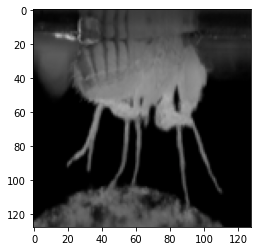

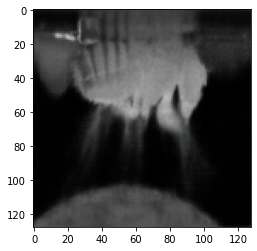

epoch 10 step 10 loss_re_AB 0.025921955704689026 loss_kl_AB 0.059438325464725494
epoch 10 step 20 loss_re_AB 0.027168691158294678 loss_kl_AB 0.05423308536410332
epoch 10 step 30 loss_re_AB 0.025825446471571922 loss_kl_AB 0.05252056196331978
epoch 10 step 40 loss_re_AB 0.026348566636443138 loss_kl_AB 0.05008803680539131
epoch 11 step 0 loss_re_AB 0.025604931637644768 loss_kl_AB 0.05047675594687462


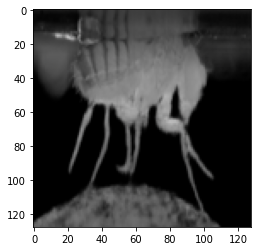

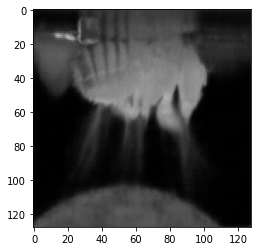

epoch 11 step 10 loss_re_AB 0.025373678654432297 loss_kl_AB 0.07297389954328537
epoch 11 step 20 loss_re_AB 0.0262649767100811 loss_kl_AB 0.07799967378377914
epoch 11 step 30 loss_re_AB 0.02632041834294796 loss_kl_AB 0.04500536248087883
epoch 11 step 40 loss_re_AB 0.02612808719277382 loss_kl_AB 0.03795555979013443
epoch 12 step 0 loss_re_AB 0.026341905817389488 loss_kl_AB 0.03684578463435173


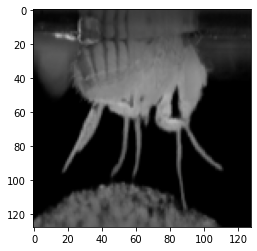

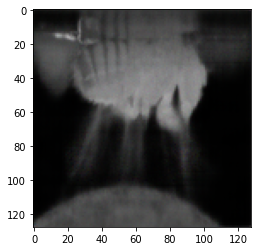

epoch 12 step 10 loss_re_AB 0.026158493012189865 loss_kl_AB 0.034187763929367065
epoch 12 step 20 loss_re_AB 0.024707620963454247 loss_kl_AB 0.03291240334510803
epoch 12 step 30 loss_re_AB 0.02632768452167511 loss_kl_AB 0.0308938417583704
epoch 12 step 40 loss_re_AB 0.025976043194532394 loss_kl_AB 0.027350788936018944
epoch 13 step 0 loss_re_AB 0.026211321353912354 loss_kl_AB 0.02600461058318615


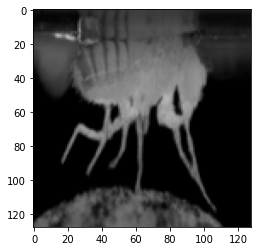

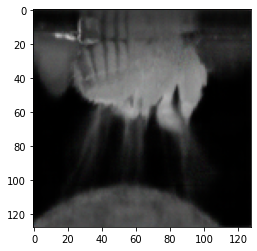

epoch 13 step 10 loss_re_AB 0.025600630789995193 loss_kl_AB 0.02468234859406948
epoch 13 step 20 loss_re_AB 0.026113754138350487 loss_kl_AB 0.022382110357284546
epoch 13 step 30 loss_re_AB 0.026564355939626694 loss_kl_AB 0.021548880264163017
epoch 13 step 40 loss_re_AB 0.025228453800082207 loss_kl_AB 0.021071139723062515
epoch 14 step 0 loss_re_AB 0.026064511388540268 loss_kl_AB 0.01884322799742222


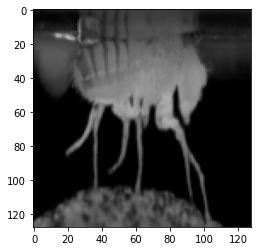

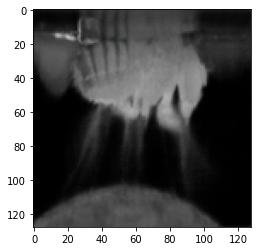

epoch 14 step 10 loss_re_AB 0.026880964636802673 loss_kl_AB 0.01720605604350567
epoch 14 step 20 loss_re_AB 0.025550197809934616 loss_kl_AB 0.015837088227272034
epoch 14 step 30 loss_re_AB 0.024816762655973434 loss_kl_AB 0.014125669375061989
epoch 14 step 40 loss_re_AB 0.025533616542816162 loss_kl_AB 0.012661335058510303
learning rate change!
epoch 15 step 0 loss_re_AB 0.025160839781165123 loss_kl_AB 0.01448560506105423


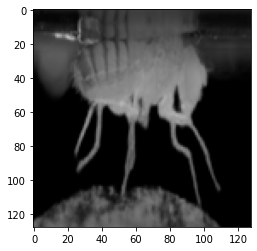

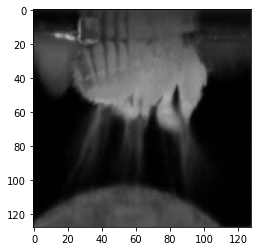

epoch 15 step 10 loss_re_AB 0.02525544911623001 loss_kl_AB 0.011640853248536587
epoch 15 step 20 loss_re_AB 0.025985032320022583 loss_kl_AB 0.010882020927965641
epoch 15 step 30 loss_re_AB 0.02538975141942501 loss_kl_AB 0.010725296102464199
epoch 15 step 40 loss_re_AB 0.025084730237722397 loss_kl_AB 0.010144881904125214
epoch 16 step 0 loss_re_AB 0.02571209892630577 loss_kl_AB 0.009849440306425095


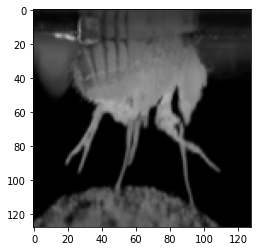

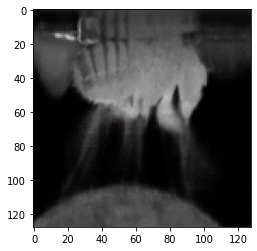

epoch 16 step 10 loss_re_AB 0.02511829510331154 loss_kl_AB 0.00942719355225563
epoch 16 step 20 loss_re_AB 0.024695653468370438 loss_kl_AB 0.009139085188508034
epoch 16 step 30 loss_re_AB 0.025540268048644066 loss_kl_AB 0.008874679915606976
epoch 16 step 40 loss_re_AB 0.025083642452955246 loss_kl_AB 0.008692587725818157
epoch 17 step 0 loss_re_AB 0.025848153978586197 loss_kl_AB 0.008612404577434063


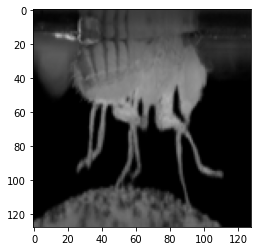

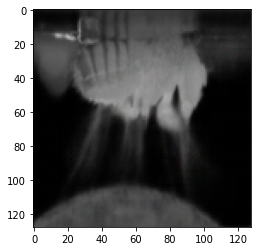

epoch 17 step 10 loss_re_AB 0.025355864316225052 loss_kl_AB 0.007886777631938457
epoch 17 step 20 loss_re_AB 0.024833617731928825 loss_kl_AB 0.007830590009689331
epoch 17 step 30 loss_re_AB 0.026334738358855247 loss_kl_AB 0.007540784310549498
epoch 17 step 40 loss_re_AB 0.024917026981711388 loss_kl_AB 0.007604147773236036
epoch 18 step 0 loss_re_AB 0.024639662355184555 loss_kl_AB 0.007241121027618647


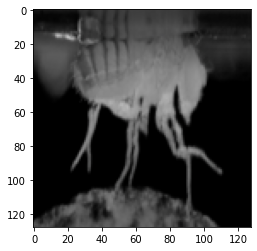

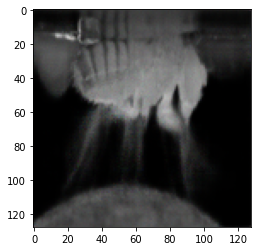

epoch 18 step 10 loss_re_AB 0.024551160633563995 loss_kl_AB 0.007358674891293049
epoch 18 step 20 loss_re_AB 0.025538403540849686 loss_kl_AB 0.007089369930326939
epoch 18 step 30 loss_re_AB 0.025964725762605667 loss_kl_AB 0.007132388651371002
epoch 18 step 40 loss_re_AB 0.024432282894849777 loss_kl_AB 0.006614206824451685
epoch 19 step 0 loss_re_AB 0.02489364892244339 loss_kl_AB 0.0067731039598584175


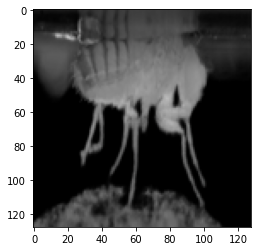

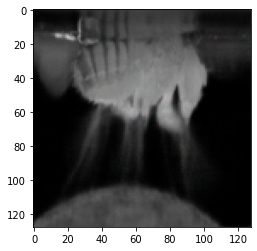

epoch 19 step 10 loss_re_AB 0.0250253826379776 loss_kl_AB 0.006613844074308872
epoch 19 step 20 loss_re_AB 0.026266438886523247 loss_kl_AB 0.006468236446380615
epoch 19 step 30 loss_re_AB 0.024982623755931854 loss_kl_AB 0.006305258255451918
epoch 19 step 40 loss_re_AB 0.025263991206884384 loss_kl_AB 0.00614654878154397
epoch 20 step 0 loss_re_AB 0.02450629696249962 loss_kl_AB 0.006123370490968227


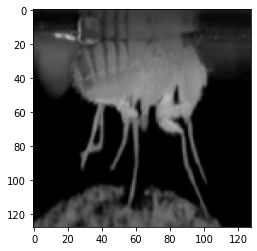

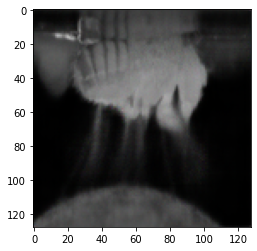

epoch 20 step 10 loss_re_AB 0.024676304310560226 loss_kl_AB 0.005960802081972361
epoch 20 step 20 loss_re_AB 0.024237167090177536 loss_kl_AB 0.005906254984438419
epoch 20 step 30 loss_re_AB 0.02437249943614006 loss_kl_AB 0.005854348186403513
epoch 20 step 40 loss_re_AB 0.025801151990890503 loss_kl_AB 0.005339167546480894
epoch 21 step 0 loss_re_AB 0.02539779804646969 loss_kl_AB 0.005850813817232847


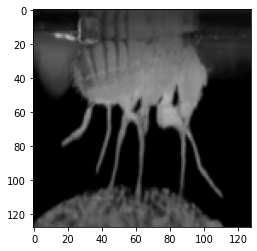

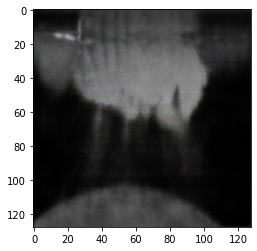

epoch 21 step 10 loss_re_AB 0.024272961542010307 loss_kl_AB 0.005565619561821222
epoch 21 step 20 loss_re_AB 0.02509165368974209 loss_kl_AB 0.005371069069951773
epoch 21 step 30 loss_re_AB 0.02390970289707184 loss_kl_AB 0.005402193870395422
epoch 21 step 40 loss_re_AB 0.025067921727895737 loss_kl_AB 0.005192496348172426
epoch 22 step 0 loss_re_AB 0.025194600224494934 loss_kl_AB 0.005003876984119415


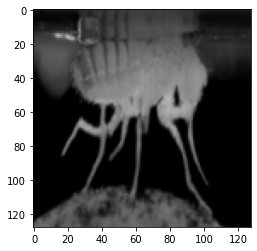

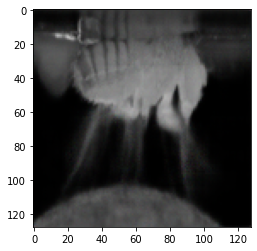

epoch 22 step 10 loss_re_AB 0.025255633518099785 loss_kl_AB 0.004992399364709854
epoch 22 step 20 loss_re_AB 0.024772314354777336 loss_kl_AB 0.005083431489765644
epoch 22 step 30 loss_re_AB 0.0239765252918005 loss_kl_AB 0.004817756358534098
epoch 22 step 40 loss_re_AB 0.025543496012687683 loss_kl_AB 0.0048310118727386
learning rate change!
epoch 23 step 0 loss_re_AB 0.025215059518814087 loss_kl_AB 0.004656300414353609


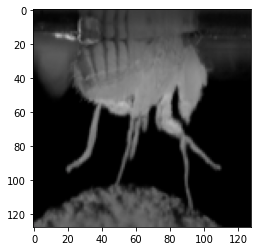

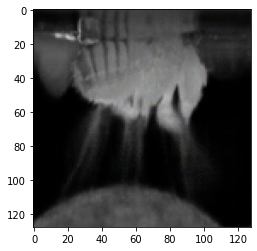

epoch 23 step 10 loss_re_AB 0.02420654520392418 loss_kl_AB 0.0046861059963703156
epoch 23 step 20 loss_re_AB 0.024795858189463615 loss_kl_AB 0.004788871854543686
epoch 23 step 30 loss_re_AB 0.025429923087358475 loss_kl_AB 0.004656163509935141
epoch 23 step 40 loss_re_AB 0.024442201480269432 loss_kl_AB 0.004662760533392429
epoch 24 step 0 loss_re_AB 0.02507762238383293 loss_kl_AB 0.004644783213734627


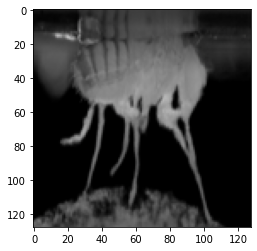

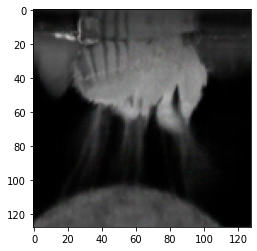

epoch 24 step 10 loss_re_AB 0.02509642206132412 loss_kl_AB 0.004591593984514475
epoch 24 step 20 loss_re_AB 0.02509690821170807 loss_kl_AB 0.004591817501932383
epoch 24 step 30 loss_re_AB 0.024777576327323914 loss_kl_AB 0.004577664192765951
epoch 24 step 40 loss_re_AB 0.025444557890295982 loss_kl_AB 0.004461954813450575
epoch 25 step 0 loss_re_AB 0.024785593152046204 loss_kl_AB 0.004601550288498402


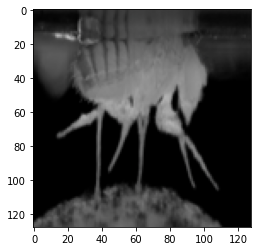

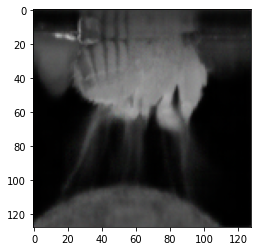

epoch 25 step 10 loss_re_AB 0.024589180946350098 loss_kl_AB 0.00454450910910964
epoch 25 step 20 loss_re_AB 0.02471074089407921 loss_kl_AB 0.004538909997791052
epoch 25 step 30 loss_re_AB 0.024986326694488525 loss_kl_AB 0.004548972938209772
epoch 25 step 40 loss_re_AB 0.02495548129081726 loss_kl_AB 0.0045416103675961494
epoch 26 step 0 loss_re_AB 0.024379519745707512 loss_kl_AB 0.004443147219717503


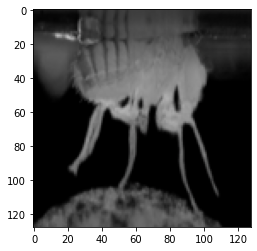

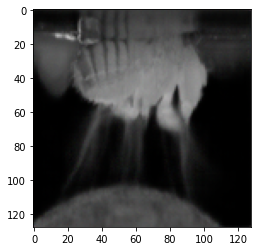

epoch 26 step 10 loss_re_AB 0.02518853358924389 loss_kl_AB 0.004333416000008583
epoch 26 step 20 loss_re_AB 0.025058448314666748 loss_kl_AB 0.004502646625041962
epoch 26 step 30 loss_re_AB 0.023925472050905228 loss_kl_AB 0.0046598585322499275
epoch 26 step 40 loss_re_AB 0.025260910391807556 loss_kl_AB 0.004332555457949638
epoch 27 step 0 loss_re_AB 0.02502308040857315 loss_kl_AB 0.004454202484339476


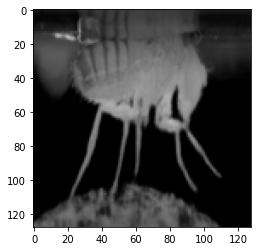

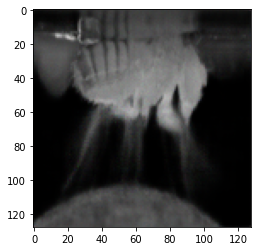

epoch 27 step 10 loss_re_AB 0.025065919384360313 loss_kl_AB 0.004327286966145039
epoch 27 step 20 loss_re_AB 0.02474011853337288 loss_kl_AB 0.004314386751502752
epoch 27 step 30 loss_re_AB 0.02447774074971676 loss_kl_AB 0.004297716077417135
epoch 27 step 40 loss_re_AB 0.024258315563201904 loss_kl_AB 0.0041495622135698795
epoch 28 step 0 loss_re_AB 0.023939987644553185 loss_kl_AB 0.004246737342327833


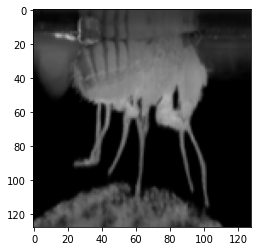

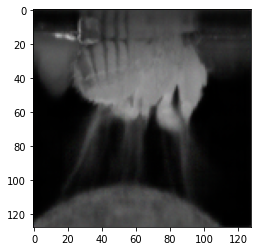

epoch 28 step 10 loss_re_AB 0.025538761168718338 loss_kl_AB 0.004435722716152668
epoch 28 step 20 loss_re_AB 0.025021491572260857 loss_kl_AB 0.004228082485496998
epoch 28 step 30 loss_re_AB 0.02435470186173916 loss_kl_AB 0.004242393188178539
epoch 28 step 40 loss_re_AB 0.025364350527524948 loss_kl_AB 0.004106930457055569
epoch 29 step 0 loss_re_AB 0.02441936731338501 loss_kl_AB 0.004232121165841818


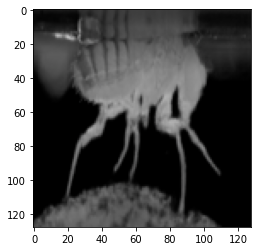

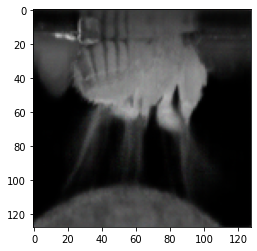

epoch 29 step 10 loss_re_AB 0.024741824716329575 loss_kl_AB 0.004060749895870686
epoch 29 step 20 loss_re_AB 0.024608304724097252 loss_kl_AB 0.004031203221529722
epoch 29 step 30 loss_re_AB 0.024015676230192184 loss_kl_AB 0.004000273533165455
epoch 29 step 40 loss_re_AB 0.02581588551402092 loss_kl_AB 0.0039795758202672005
epoch 30 step 0 loss_re_AB 0.02431173250079155 loss_kl_AB 0.004167081322520971


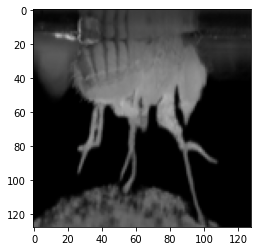

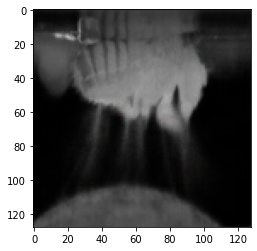

epoch 30 step 10 loss_re_AB 0.02442759834229946 loss_kl_AB 0.004015169572085142
epoch 30 step 20 loss_re_AB 0.025029903277754784 loss_kl_AB 0.003921979572623968
epoch 30 step 30 loss_re_AB 0.0256512314081192 loss_kl_AB 0.004146450199186802
epoch 30 step 40 loss_re_AB 0.023722589015960693 loss_kl_AB 0.004035466816276312
learning rate change!
epoch 31 step 0 loss_re_AB 0.02490905486047268 loss_kl_AB 0.00390662020072341


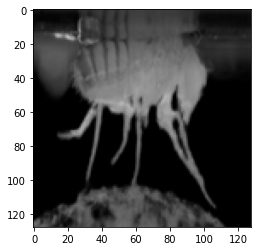

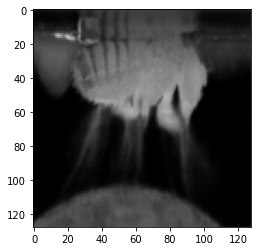

epoch 31 step 10 loss_re_AB 0.02379193902015686 loss_kl_AB 0.0039048343896865845
epoch 31 step 20 loss_re_AB 0.024664361029863358 loss_kl_AB 0.003935751039534807
epoch 31 step 30 loss_re_AB 0.024254832416772842 loss_kl_AB 0.003882861929014325
epoch 31 step 40 loss_re_AB 0.024857541546225548 loss_kl_AB 0.003988396842032671
epoch 32 step 0 loss_re_AB 0.023210695013403893 loss_kl_AB 0.0040285950526595116


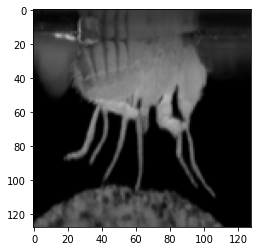

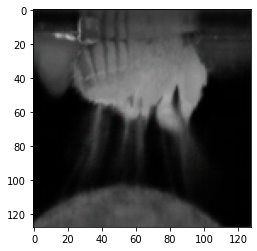

epoch 32 step 10 loss_re_AB 0.024565216153860092 loss_kl_AB 0.003921318333595991
epoch 32 step 20 loss_re_AB 0.024975186213850975 loss_kl_AB 0.0038454518653452396
epoch 32 step 30 loss_re_AB 0.024763014167547226 loss_kl_AB 0.00399567699059844
epoch 32 step 40 loss_re_AB 0.02443019673228264 loss_kl_AB 0.0038687095511704683
epoch 33 step 0 loss_re_AB 0.025388970971107483 loss_kl_AB 0.0038614191580563784


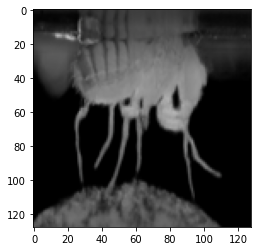

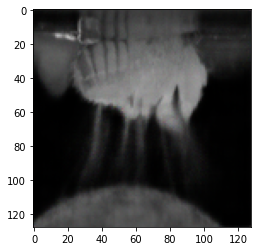

epoch 33 step 10 loss_re_AB 0.02508213184773922 loss_kl_AB 0.003970076330006123
epoch 33 step 20 loss_re_AB 0.024792654439806938 loss_kl_AB 0.003928956110030413
epoch 33 step 30 loss_re_AB 0.023835625499486923 loss_kl_AB 0.0037656151689589024
epoch 33 step 40 loss_re_AB 0.024040304124355316 loss_kl_AB 0.0037103944923728704
epoch 34 step 0 loss_re_AB 0.02552107535302639 loss_kl_AB 0.003796922042965889


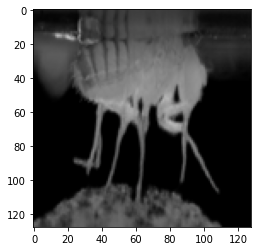

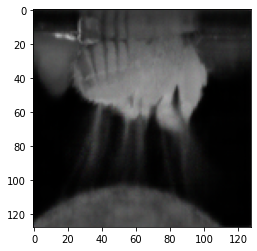

epoch 34 step 10 loss_re_AB 0.0241677388548851 loss_kl_AB 0.0038152076303958893
epoch 34 step 20 loss_re_AB 0.02424057386815548 loss_kl_AB 0.003893611952662468
epoch 34 step 30 loss_re_AB 0.0253940187394619 loss_kl_AB 0.003949283622205257
epoch 34 step 40 loss_re_AB 0.024703655391931534 loss_kl_AB 0.0038685468025505543
epoch 35 step 0 loss_re_AB 0.025046873837709427 loss_kl_AB 0.0038332592230290174


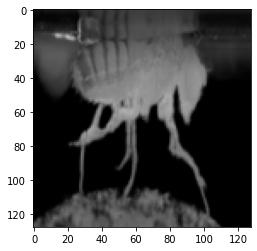

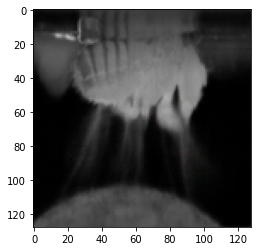

epoch 35 step 10 loss_re_AB 0.024661948904395103 loss_kl_AB 0.0037745654117316008
epoch 35 step 20 loss_re_AB 0.025216486304998398 loss_kl_AB 0.003787476569414139
epoch 35 step 30 loss_re_AB 0.02482966147363186 loss_kl_AB 0.003682987531647086
epoch 35 step 40 loss_re_AB 0.025587311014533043 loss_kl_AB 0.003834235016256571
epoch 36 step 0 loss_re_AB 0.024973910301923752 loss_kl_AB 0.0037597285117954016


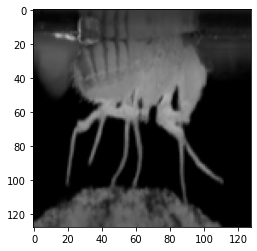

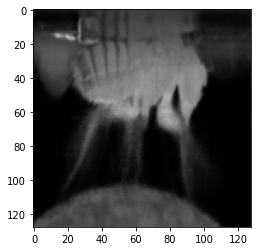

epoch 36 step 10 loss_re_AB 0.024692311882972717 loss_kl_AB 0.0037004672922194004
epoch 36 step 20 loss_re_AB 0.02544664591550827 loss_kl_AB 0.0038085312116891146
epoch 36 step 30 loss_re_AB 0.025191109627485275 loss_kl_AB 0.0038164076395332813
epoch 36 step 40 loss_re_AB 0.023746710270643234 loss_kl_AB 0.0037025741767138243
epoch 37 step 0 loss_re_AB 0.02406046912074089 loss_kl_AB 0.003767959773540497


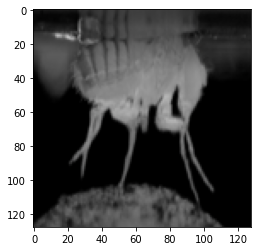

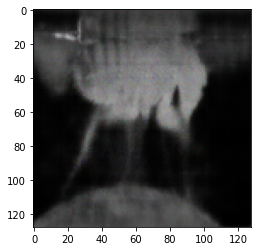

epoch 37 step 10 loss_re_AB 0.025227807462215424 loss_kl_AB 0.003716683480888605
epoch 37 step 20 loss_re_AB 0.02370539866387844 loss_kl_AB 0.0037479542661458254
epoch 37 step 30 loss_re_AB 0.024090111255645752 loss_kl_AB 0.0039053268264979124
epoch 37 step 40 loss_re_AB 0.024186041206121445 loss_kl_AB 0.0037744888104498386
epoch 38 step 0 loss_re_AB 0.02417757920920849 loss_kl_AB 0.003753087716177106


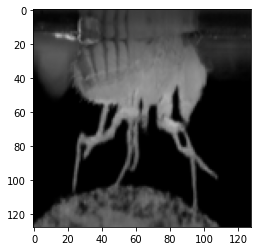

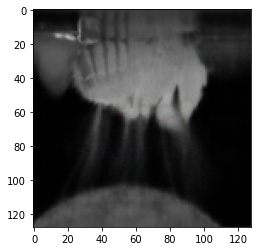

epoch 38 step 10 loss_re_AB 0.024125654250383377 loss_kl_AB 0.0036246750969439745
epoch 38 step 20 loss_re_AB 0.024721181020140648 loss_kl_AB 0.003674955340102315
epoch 38 step 30 loss_re_AB 0.025306841358542442 loss_kl_AB 0.003713628277182579
epoch 38 step 40 loss_re_AB 0.024105509743094444 loss_kl_AB 0.00394123001024127
learning rate change!
epoch 39 step 0 loss_re_AB 0.02453247271478176 loss_kl_AB 0.0037176671903580427


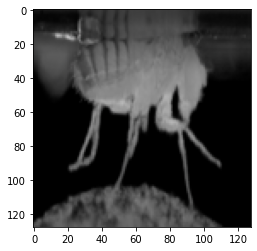

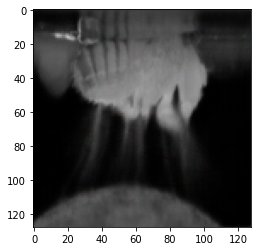

epoch 39 step 10 loss_re_AB 0.025202980265021324 loss_kl_AB 0.00366733456030488
epoch 39 step 20 loss_re_AB 0.024365579709410667 loss_kl_AB 0.0035915689077228308
epoch 39 step 30 loss_re_AB 0.02510577067732811 loss_kl_AB 0.0036500643473118544
epoch 39 step 40 loss_re_AB 0.024921070784330368 loss_kl_AB 0.003674006089568138


In [13]:
# Initialize the network
vae = VAE(zsize=512).cuda()

# Initialize the optimizers
lr = 0.0005
vae_optimizer = optim.Adam(vae.parameters(), lr=lr, betas=(0.5, 0.999), weight_decay=1e-5)
train_epoch = 40

# For storing results
rec_loss_AB = []
kl_loss_AB  = []

for epoch in range(train_epoch):
    vae.train() # Training mode

    if (epoch + 1) % 8 == 0: # Adaptive learning rate
        vae_optimizer.param_groups[0]['lr'] /= 4
        print("learning rate change!")

    for i, data in enumerate(dataloader):
        vae.zero_grad()
        
        img_A = data['A'].cuda()
        img_B = data['B'].cuda()
        img_AB = torch.cat((img_A, img_B))

        # The embeddings
        rec_AB, mu_AB, logvar_AB = vae(img_AB)

        # The loss function --------------------------------------------------------------------------------
        loss_re_AB, loss_kl_AB = loss_function(rec_AB, img_AB, mu_AB, logvar_AB)

        # Backward -----------------------------------------------------------------------------------------
        (loss_re_AB + loss_kl_AB).backward()
        vae_optimizer.step()

        # Store values -------------------------------------------------------------------------------------
        rec_loss_AB += [loss_re_AB.item()]
        kl_loss_AB += [loss_kl_AB.item()]

        # --------------------------------------------------------------------------------------------------

        # Print statistics
        if i % 10 == 0:
            print('epoch', epoch, 'step', i,
                  'loss_re_AB', loss_re_AB.item(), 'loss_kl_AB', loss_kl_AB.item())

        if i % 50 == 0: # Visualize output now and then
            visualize(img_AB[0].cpu())
            visualize(rec_AB[0].detach().cpu())

## Results of the VAE training

In [16]:
def smooth(list):
  return signal.savgol_filter(list, 101, 3)

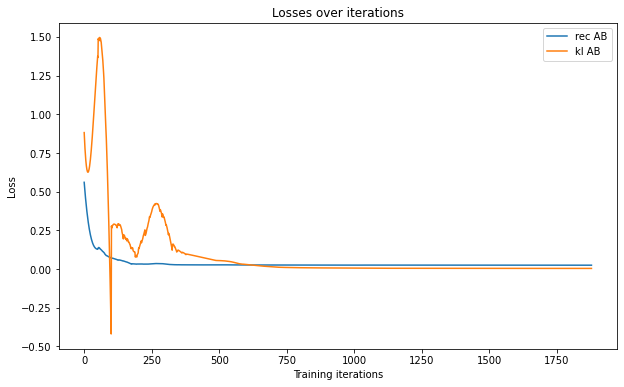

In [18]:
plt.figure(figsize=(10,6))
plt.title('Losses over iterations')
plt.xlabel('Training iterations')
plt.ylabel('Loss')
plt.plot(smooth(rec_loss_AB))
plt.plot(smooth(kl_loss_AB))
plt.legend(['rec AB', 'kl AB'])
plt.show()

## VAE latent space analyzation

In [9]:
# Save model
# torch.save(vae.state_dict(), '/content/vae')

# Load model
vae = VAE(zsize=512).cuda()
vae.load_state_dict(torch.load('/content/vae'))
vae.eval()

VAE(
  (conv1): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv1_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv3_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv4_bn): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(1024, 2048, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv5_bn): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=32768, out_features=512, bias=True)
  (fc2): Linear(in_features=32768, out_features=512, bias=

In [71]:
batch_size = 32
dataloader_all = DataLoader(dataset, batch_size, shuffle=True)

recs_AB = ()
mus_AB = ()
vars_AB = ()

for i, data in enumerate(dataloader_all):
  data_AB = torch.cat((data['A'], data['B']))
  rec_AB, mu_AB, var_AB = vae(data_AB.cuda())
  recs_AB += (rec_AB.detach().cpu(), )
  mus_AB += (mu_AB.detach().cpu(), )
  vars_AB += (var_AB.detach().cpu(), )

recs_AB = torch.cat(recs_AB)
mus_AB = torch.cat(mus_AB)
vars_AB = torch.cat(vars_AB)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [72]:
# Perform t-SNE embedding
embedded_mu = TSNE(n_components=2).fit_transform(mus_AB.detach().cpu())
embedded_var = TSNE(n_components=2).fit_transform(vars_AB.detach().cpu())

In [73]:
# Get the right labels
idx = torch.zeros(3000, dtype=torch.uint8)
for i in range(93):
  if i % 2 == 0:
    idx[32*i:32*(i+1)] = 1
  
idx_A = idx==1
idx_B = idx==0

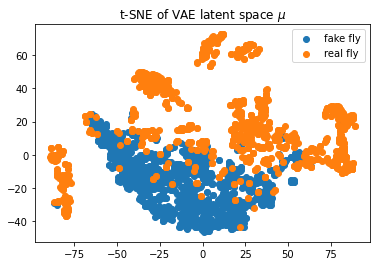

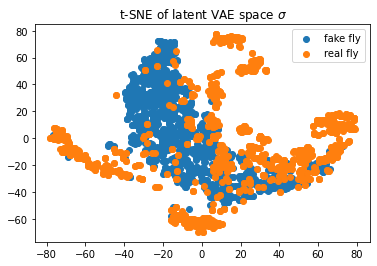

In [74]:
plt.title('t-SNE of VAE latent space $\mu$')
plt.scatter(embedded_mu[idx_A, 0], embedded_mu[idx_A, 1])
plt.scatter(embedded_mu[idx_B, 0], embedded_mu[idx_B, 1])
plt.legend(['fake fly', 'real fly'])
plt.show()

plt.title('t-SNE of latent VAE space $\sigma$')
plt.scatter(embedded_var[idx_A, 0], embedded_var[idx_A, 1])
plt.scatter(embedded_var[idx_B, 0], embedded_var[idx_B, 1])
plt.legend(['fake fly', 'real fly'])
plt.show()

In [75]:
def visualize_grid(img):
  plt.figure(figsize=(15,15))
  plt.imshow((img.permute(1,2,0) + 1) / 2)
  plt.axis('off')
  plt.show()

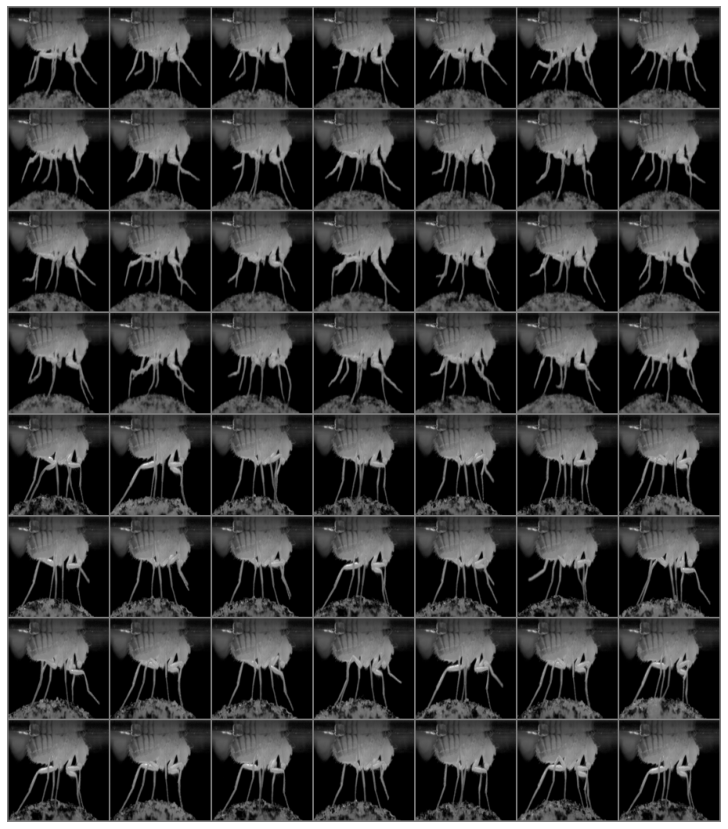

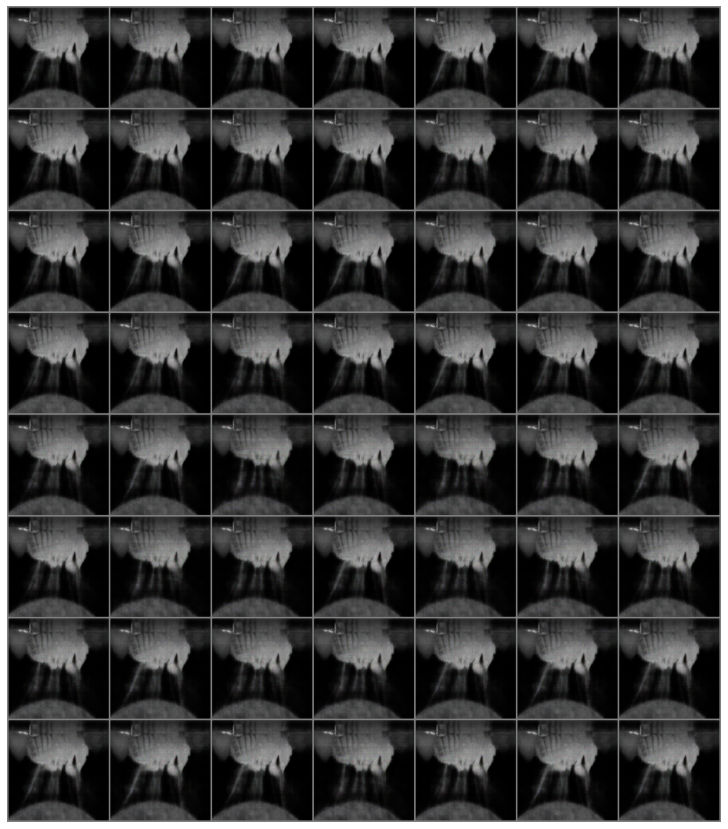

In [76]:
visualize_grid(make_grid(data_AB, nrow=7))
visualize_grid(make_grid(rec_AB.detach().cpu(), nrow=7))

## Distribution network

In [77]:
class WeightNet(nn.Module):
    '''A simple network that predicts the importances of the samples'''

    def __init__(self):
        super(WeightNet, self).__init__()
        self.softmax = nn.Softmax(dim=0)

        self.conv1 = nn.Conv2d(3, 10, kernel_size=7)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv3 = nn.Conv2d(20, 40, kernel_size=5)
        self.fc1 = nn.Linear(40*12*12, 40)
        self.fc2 = nn.Linear(40, 1)
        
    def forward(self, x):
        h1 = torch.sigmoid(F.max_pool2d(self.conv1(x), 2))
        h2 = torch.sigmoid(F.max_pool2d(self.conv2(h1), 2))
        h3 = torch.sigmoid(F.max_pool2d(self.conv3(h2), 2))
        h4 = h3.view(-1, 40*12*12)
        h5 = torch.sigmoid(self.fc1(h4))
        out = self.fc2(h5)
        return self.softmax(out), out

In [78]:
def n_centered_moment(x, w, n):
  if n > 1:
    c = n_centered_moment(x, w, 1)
  else:
    c = 0
  return (((x - c)**n)*w).sum(0)

## Training of distribution net

In [80]:
# Initialize the networks
weight_network = WeightNet().cuda()
# Initialize the optimizers
lr = 0.01
optimizer_w = optim.Adam(weight_network.parameters(), lr=lr)

criterion_w = nn.MSELoss()

# For storing results
losses_w = []

means_A = []
means_B = []

vars_A = []
vars_B = []

moments_A = []
moments_B = []

example_importances_A = []

n = 1 # n-centered moment

vae.eval()

for epoch in range(5):
    for i, data in enumerate(dataloader):
        
        img_A = data['A'].cuda()
        img_B = data['B'].cuda()

        # The embeddings
        rec_A, mu_A, logvar_A = vae(img_A)
        rec_B, mu_B, logvar_B = vae(img_B)

        # The weighting process
        w_A = weight_network(img_A)[0]
        w_B = 1/len(img_B)

        # The loss function --------------------------------------------------------------------------------
        n_centered_moment_A_mu = n_centered_moment(mu_A.detach(), w_A, n)
        n_centered_moment_B_mu = n_centered_moment(mu_B.detach(), w_B, n)
        # n_centered_moment_A_var = n_centered_moment(var_A.detach(), w_A, n)
        # n_centered_moment_B_var = n_centered_moment(var_B.detach(), w_B, n)
        loss_w = criterion_w(n_centered_moment_A_mu, n_centered_moment_B_mu)

        # ---------------------------------------------------------------------------------------------------

        # Backward
        optimizer_w.zero_grad()
        loss_w.backward()
        optimizer_w.step() 

        # Store values --------------------------------------------------------------------------------------
        moments_A += [n_centered_moment_A.cpu().detach().numpy()]
        moments_B += [n_centered_moment_B.cpu().detach().numpy()]

        means_A += [n_centered_moment(mu_A, w_A, 1).detach().cpu().numpy()]
        means_B += [n_centered_moment(mu_B, w_B, 1).detach().cpu().numpy()]

        vars_A += [n_centered_moment(mu_A, w_A, 2).detach().cpu().numpy()]
        vars_B += [n_centered_moment(mu_B, w_B, 2).detach().cpu().numpy()]    

        losses_w += [loss_w.item()]

        # ---------------------------------------------------------------------------------------------------

        # Print statistics
        if i % 10 == 0:
            print('epoch', epoch, 'step', i, 'loss_w: ', loss_w.item())
            
        if i % 10000 == 0 and i != 0:
            break

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


epoch 0 step 0 loss_w:  0.004420875571668148
epoch 0 step 10 loss_w:  0.005471817217767239
epoch 0 step 20 loss_w:  0.0011672043474391103
epoch 0 step 30 loss_w:  0.0014109800104051828
epoch 0 step 40 loss_w:  0.002418181160464883
epoch 1 step 0 loss_w:  0.0012645984534174204
epoch 1 step 10 loss_w:  0.0011705924989655614
epoch 1 step 20 loss_w:  0.0005194647237658501
epoch 1 step 30 loss_w:  0.0022767947521060705
epoch 1 step 40 loss_w:  0.0009258720092475414
epoch 2 step 0 loss_w:  0.0013993645552545786
epoch 2 step 10 loss_w:  0.002867732662707567
epoch 2 step 20 loss_w:  0.0009150538244284689
epoch 2 step 30 loss_w:  0.0018546475330367684
epoch 2 step 40 loss_w:  0.0009572029812261462
epoch 3 step 0 loss_w:  0.0008411011076532304
epoch 3 step 10 loss_w:  0.0013622348196804523
epoch 3 step 20 loss_w:  0.0024398379027843475
epoch 3 step 30 loss_w:  0.0013946982799097896
epoch 3 step 40 loss_w:  0.0012871443759649992
epoch 4 step 0 loss_w:  0.000911390467081219
epoch 4 step 10 loss_w:

In [81]:
moments_A = torch.Tensor(moments_A)
moments_B = torch.Tensor(moments_B)
means_A = torch.Tensor(means_A)
means_B = torch.Tensor(means_B)
vars_A = torch.Tensor(vars_A)
vars_B = torch.Tensor(vars_B)

## Results of the weightnet

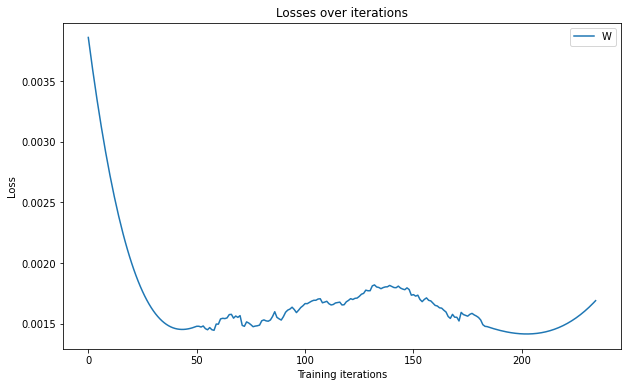

In [82]:
plt.figure(figsize=(10,6))
plt.title('Losses over iterations')
plt.xlabel('Training iterations')
plt.ylabel('Loss')
smoothed_losses_w = signal.savgol_filter(losses_w,101,3)
plt.plot(smoothed_losses_w)
plt.legend(['W'])
plt.show()

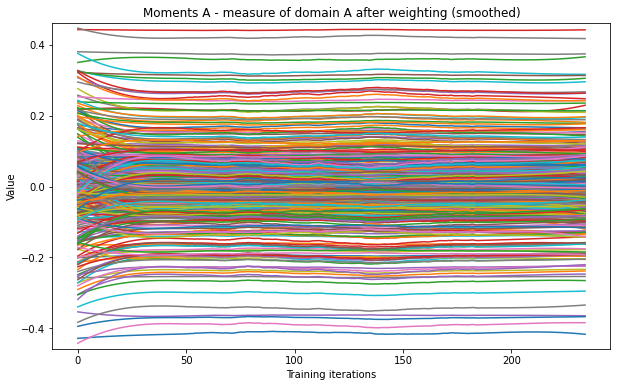

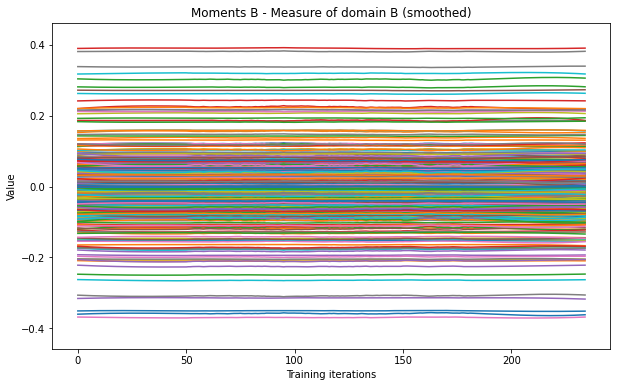

In [83]:
plt.figure(figsize=(10,6))
plt.title('Moments A - measure of domain A after weighting (smoothed)')
plt.xlabel('Training iterations')
plt.ylabel('Value')
plt.ylim(ymax = moments_A.max(), ymin = moments_A.min())
smoothed_Lmin = signal.savgol_filter(moments_A,101,3,axis=0)
plt.plot(smoothed_Lmin)
# plt.legend(np.arange(len(moments_A[0])))
plt.show()

plt.figure(figsize=(10,6))
plt.title('Moments B - Measure of domain B (smoothed)')
plt.xlabel('Training iterations')
plt.ylabel('Value')
plt.ylim(ymax = moments_A.max(), ymin = moments_A.min())
smoothed_Lplus = signal.savgol_filter(moments_B,101,3,axis=0)
plt.plot(smoothed_Lplus)
# plt.legend(np.arange(len(moments_A[0])))
plt.show()

Image with weight 0.0687183290719986


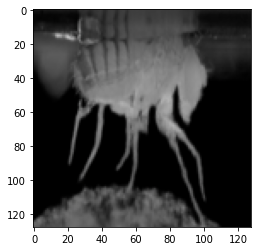

Image with weight 0.05294173210859299


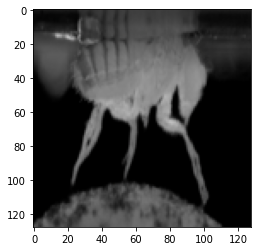

Image with weight 0.048588868230581284


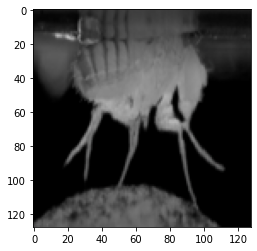

Image with weight 4.126668453216553


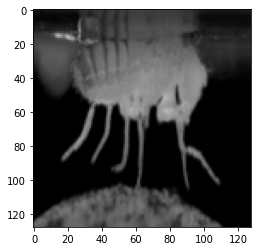

Image with weight 6.209132671356201


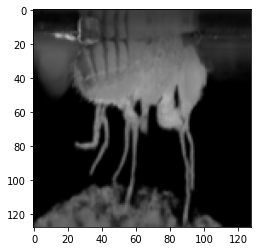

Image with weight 0.1122637614607811


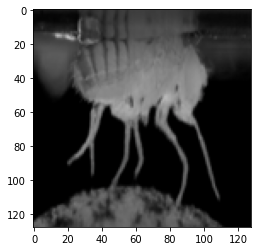

Image with weight 0.07299365848302841


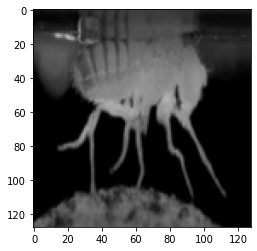

Image with weight 0.06257314234972


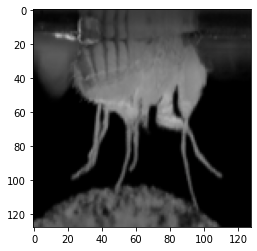

Image with weight 1.3281686305999756


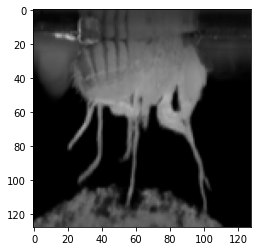

Image with weight 1.6970453262329102


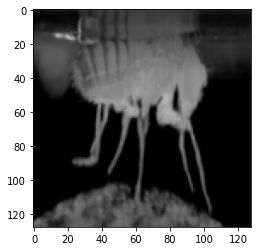

Image with weight 0.0652264654636383


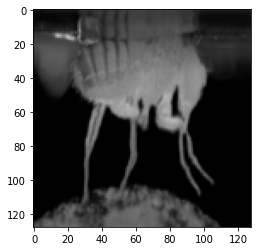

Image with weight 6.37623929977417


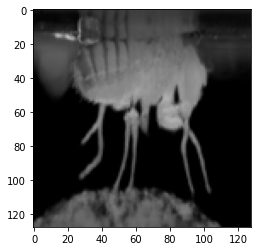

Image with weight 0.06978297978639603


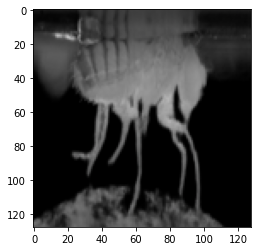

Image with weight 0.07697765529155731


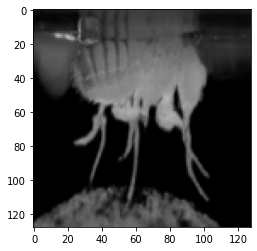

Image with weight 0.07041385024785995


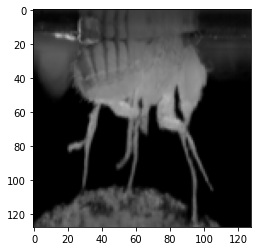

Image with weight 0.06751083582639694


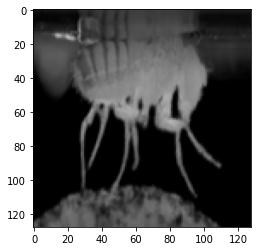

Image with weight 0.07236811518669128


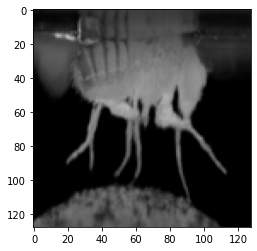

Image with weight 0.0763755515217781


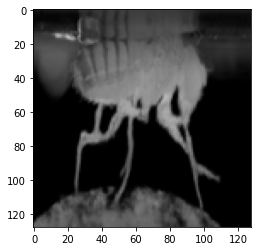

Image with weight 0.19489800930023193


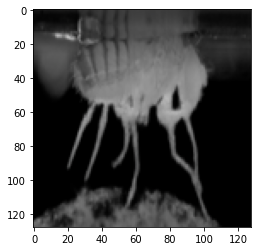

Image with weight 0.12374845147132874


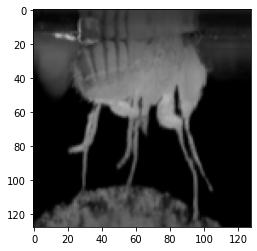

Image with weight 0.06514859199523926


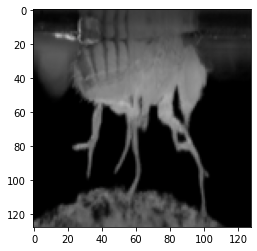

Image with weight 0.061033956706523895


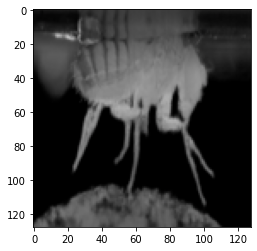

Image with weight 6.34725284576416


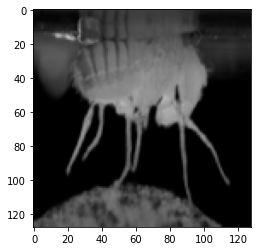

Image with weight 0.0875670462846756


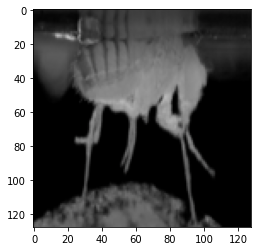

Image with weight 0.2968255281448364


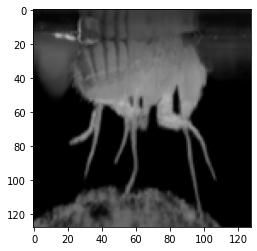

Image with weight 0.05336817353963852


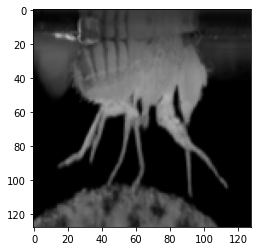

Image with weight 0.05785129591822624


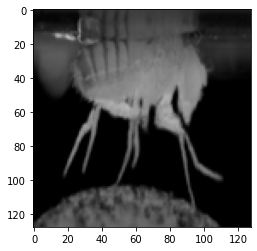

Image with weight 0.058316126465797424


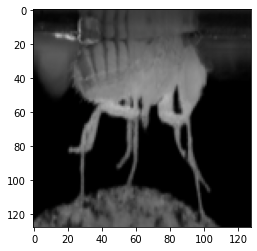

In [84]:
# These are generated images
weights = weight_network(img_A)[0]
weights *= len(weights)

for image, weight in zip(img_A, weights):
  print('Image with weight', weight.item())
  visualize(image.cpu())